# Resolution Study: D8 vs D-infinity

Mirrors `supp_fig6.ipynb` but adds D-infinity flow routing alongside D8.
For each (location, tile, dx), we compute both D8 and D-inf AD models and
compare their Ks_mod/Ks_obs ratio vs. grid resolution.

Same tiles, parameters, and dx range (5–100 m, 25 log-spaced steps).

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../../src')))

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext

import TopoAnalysis.dem as d

from models import advection_diffusion_model
from models_dinf import advection_diffusion_model_dinf
from dinf import compute_dinf_flow_direction, compute_dinf_area
from plotting import set_nature_style
from utils import resample_from_1m
from analysis import ks_obs_from_observed, ks_mod_from_modeled

set_nature_style()

In [2]:
# ============================================================
# Configuration
# ============================================================
BASE_ROOT = os.path.abspath('../../data')

N_DX = 25
DX_TARGETS = np.logspace(np.log10(5.0), np.log10(100.0), N_DX)
DX_TARGETS = np.unique(np.sort(DX_TARGETS)).tolist()

MIN_AREA = 1e5
RESAMPLE_ORDER = 1

U_BY_LOC = {'GM': 1.47e-4, 'AP': 5.5e-5}

KD_GM = {
    1: (2.2e-05, 1.0e-02),
    2: (6.1e-05, 1.0e-02),
    3: (1.9e-05, 2.1e-02),
    4: (3.5e-05, 9.8e-03),
    5: (5.9e-05, 9.0e-03),
}
KD_AP = {
    1: (4.0e-07, 2.8e-03),
    2: (2.9e-07, 2.8e-03),
    3: (4.9e-07, 2.7e-03),
    4: (2.0e-06, 2.5e-03),
    5: (3.6e-06, 2.5e-03),
}

THETA_GM = {1: 0.379, 2: 0.308, 3: 0.417, 4: 0.313, 5: 0.300}
THETA_AP = {1: 0.562, 2: 0.592, 3: 0.542, 4: 0.438, 5: 0.400}


def tile_dir(location, tile_idx):
    return os.path.join(BASE_ROOT, location, f'tile{tile_idx}')


def root_1m_filled(location, tile_idx):
    base = tile_dir(location, tile_idx)
    p = os.path.join(base, f'{location}_1m_best_tile_filled')
    if not os.path.exists(p):
        raise FileNotFoundError(f'Missing 1m filled root: {p}')
    return p


print(f'Data root: {BASE_ROOT}')
print(f'dx range: {DX_TARGETS[0]:.1f} – {DX_TARGETS[-1]:.1f} m ({len(DX_TARGETS)} steps)')

Data root: /Users/scdobbs/Documents/GitHub/Manuscript_submission/data
dx range: 5.0 – 100.0 m (25 steps)


## Main Loop

For each (location, tile, dx):
1. Resample 1m DEM to target dx
2. Recompute D8 hydrology
3. Compute D-inf routing from resampled DEM (D8 fd as flat-cell fallback)
4. Run D8 AD model
5. Run D-inf AD model
6. Compute Ks_obs, Ks_mod_d8, Ks_mod_dinf, and their ratios

In [3]:
def run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, D, theta):
    """Run both D8 and D-inf AD models at a given resolution."""
    # 1) Downsample
    if np.isclose(dx_target, 1.0):
        dem_dx = dem_1m_filled
    else:
        dem_dx = resample_from_1m(dem_1m_filled, dx_target=float(dx_target), order=RESAMPLE_ORDER)

    # 2) D8 hydrology at this resolution
    filled_obs = d.FilledElevation(elevation=dem_dx)
    fd = d.FlowDirectionD8(flooded_dem=filled_obs)
    area = d.Area(flow_direction=fd)

    # 3) D-inf routing (D8 fd as flat-cell fallback)
    Z = filled_obs._griddata
    dx_val = dem_dx._georef_info.dx
    angles, r_facet, facet_idx = compute_dinf_flow_direction(Z, dx_val, FD_d8=fd._griddata)
    A_dinf = compute_dinf_area(Z, dx_val, angles, r_facet, facet_idx)

    # 4) Ks_obs (same for both D8 and D-inf, uses D8 slopes)
    Ks_obs, r2_obs, n_obs, Amax_obs = ks_obs_from_observed(filled_obs, area, fd, theta)

    # 5) D8 AD model
    solver_d8 = advection_diffusion_model(dem_dx, area, fd, theta)
    Z_d8 = solver_d8(U, K, D)
    Ks_d8, r2_d8, n_d8, Amax_d8 = ks_mod_from_modeled(Z_d8, dem_dx, area, fd, theta)

    # 6) D-inf AD model
    solver_dinf = advection_diffusion_model_dinf(
        dem_dx, area, fd, theta, angles, r_facet, facet_idx, A_dinf,
    )
    Z_dinf = solver_dinf(U, K, D)
    Ks_dinf, r2_dinf, n_dinf, Amax_dinf = ks_mod_from_modeled(Z_dinf, dem_dx, area, fd, theta)

    # Ratios
    ratio_d8 = float(Ks_d8 / Ks_obs) if (np.isfinite(Ks_d8) and np.isfinite(Ks_obs) and Ks_obs > 0) else np.nan
    ratio_dinf = float(Ks_dinf / Ks_obs) if (np.isfinite(Ks_dinf) and np.isfinite(Ks_obs) and Ks_obs > 0) else np.nan

    return {
        'location': location, 'tile': tile_idx, 'dx': float(dx_target),
        'U': U, 'K': K, 'D': D, 'theta': theta,
        'Ks_obs': float(Ks_obs),
        'Ks_d8': float(Ks_d8), 'ratio_d8': ratio_d8,
        'Ks_dinf': float(Ks_dinf), 'ratio_dinf': ratio_dinf,
    }


# Run all combinations
all_results = []
all_errors = []

for location in ['GM', 'AP']:
    U = U_BY_LOC[location]
    KD = KD_GM if location == 'GM' else KD_AP
    TH = THETA_GM if location == 'GM' else THETA_AP

    for tile_idx in [1, 2, 3, 4, 5]:
        try:
            p = root_1m_filled(location, tile_idx)
            dem_1m_filled = d.FilledElevation.load(p)
        except Exception as e:
            all_errors.append((location, tile_idx, 'LOAD_1M', str(e)))
            print(f'[FAIL] {location} Tile {tile_idx}: {e}')
            continue

        K, Dcoef = KD[tile_idx]
        theta = TH[tile_idx]

        for dx_target in DX_TARGETS:
            try:
                r = run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, Dcoef, theta)
                all_results.append(r)
                print(
                    f'[OK] {location} T{tile_idx} dx={dx_target:6.2f} | '
                    f'ratio_d8={r["ratio_d8"]:.3f} ratio_dinf={r["ratio_dinf"]:.3f}'
                )
            except Exception as e:
                all_errors.append((location, tile_idx, dx_target, str(e)))
                print(f'[FAIL] {location} T{tile_idx} dx={dx_target}: {e}')

if len(all_results) == 0:
    raise RuntimeError('No successful runs. Inspect all_errors.')

print(f'\nCompleted: {len(all_results)} runs, {len(all_errors)} errors')

[OK] GM T1 dx=  5.00 | ratio_d8=11.891 ratio_dinf=11.977
[OK] GM T1 dx=  5.66 | ratio_d8=11.001 ratio_dinf=10.973
[OK] GM T1 dx=  6.42 | ratio_d8=10.193 ratio_dinf=10.041
[OK] GM T1 dx=  7.27 | ratio_d8=9.122 ratio_dinf=9.016
[OK] GM T1 dx=  8.24 | ratio_d8=8.221 ratio_dinf=8.100
[OK] GM T1 dx=  9.33 | ratio_d8=7.538 ratio_dinf=7.385
[OK] GM T1 dx= 10.57 | ratio_d8=6.452 ratio_dinf=6.325
[OK] GM T1 dx= 11.98 | ratio_d8=5.733 ratio_dinf=5.638
[OK] GM T1 dx= 13.57 | ratio_d8=5.175 ratio_dinf=5.070
[OK] GM T1 dx= 15.38 | ratio_d8=4.531 ratio_dinf=4.487
[OK] GM T1 dx= 17.42 | ratio_d8=4.162 ratio_dinf=4.114
[OK] GM T1 dx= 19.74 | ratio_d8=3.675 ratio_dinf=3.677
[OK] GM T1 dx= 22.36 | ratio_d8=3.315 ratio_dinf=3.271
[OK] GM T1 dx= 25.33 | ratio_d8=2.938 ratio_dinf=2.977
[OK] GM T1 dx= 28.70 | ratio_d8=2.594 ratio_dinf=2.630
[OK] GM T1 dx= 32.52 | ratio_d8=2.236 ratio_dinf=2.265
[OK] GM T1 dx= 36.84 | ratio_d8=2.037 ratio_dinf=2.013
[OK] GM T1 dx= 41.74 | ratio_d8=1.834 ratio_dinf=1.826
[OK]

## Plotting Helpers

In [4]:
def group_stats(all_results, loc, dx_grid, key='ratio_d8'):
    """Compute median and IQR of a ratio field across tiles for one location."""
    vals_by_dx = {float(dx): [] for dx in dx_grid}
    for r in all_results:
        if r['location'] != loc:
            continue
        dx = float(r['dx'])
        for d_target in dx_grid:
            if np.isclose(dx, float(d_target), atol=1e-10):
                v = r[key]
                if np.isfinite(v) and v > 0:
                    vals_by_dx[float(d_target)].append(v)
                break

    med, q25, q75 = [], [], []
    for dx in dx_grid:
        arr = np.array(vals_by_dx[float(dx)], dtype=float)
        if arr.size == 0:
            med.append(np.nan); q25.append(np.nan); q75.append(np.nan)
        else:
            med.append(np.nanmedian(arr))
            q25.append(np.nanpercentile(arr, 25))
            q75.append(np.nanpercentile(arr, 75))
    return np.array(med), np.array(q25), np.array(q75)


def plot_median_iqr(ax, x, med, q25, q75, color, marker, linestyle, label=None):
    x = np.asarray(x, float)
    med = np.asarray(med, float)
    q25 = np.asarray(q25, float)
    q75 = np.asarray(q75, float)

    m = np.isfinite(x) & np.isfinite(med) & np.isfinite(q25) & np.isfinite(q75) & (med > 0)
    if np.sum(m) < 2:
        return

    ax.fill_between(
        x[m], q25[m], q75[m],
        facecolor=color, alpha=0.15, linewidth=0, edgecolor='none',
        interpolate=True, zorder=1,
    )
    ax.plot(
        x[m], med[m], linestyle + marker,
        color=color, lw=0.9, ms=2.4,
        mfc=color, mec=color, mew=0.0,
        zorder=3, label=label,
    )

## Plot: Ks_mod/Ks_obs Ratio vs. dx — D8 and D-inf on Same Axes

Solid lines = D8, dashed lines = D-inf. Separate colors per location.

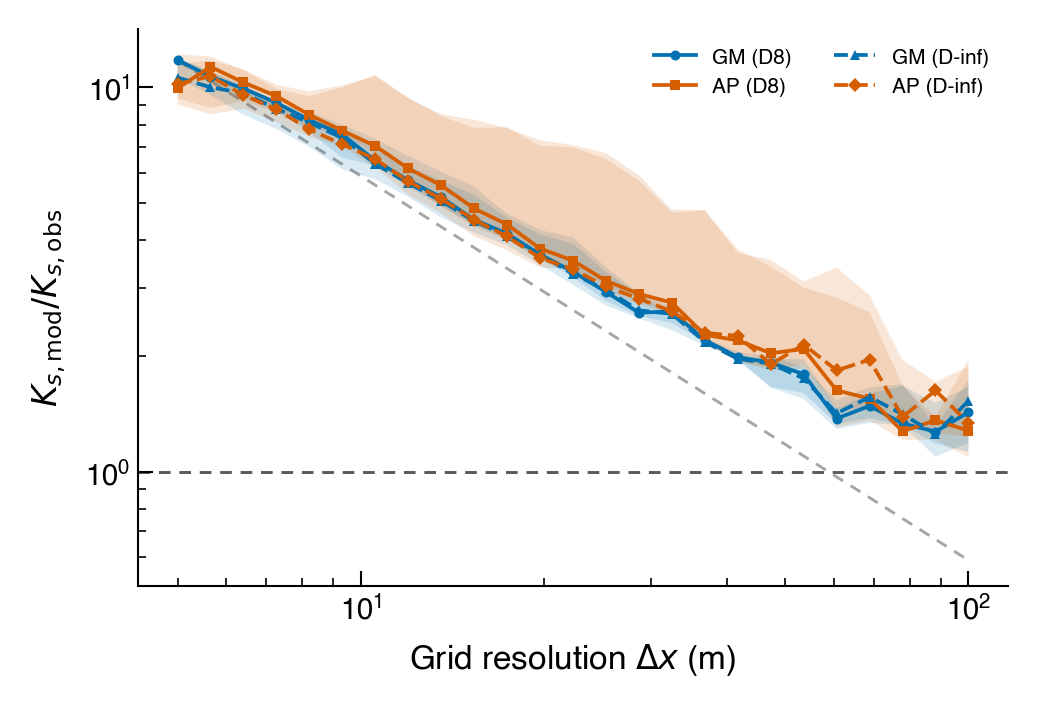

In [5]:
dx_all = np.array(sorted({float(r['dx']) for r in all_results}), dtype=float)

COL_GM = '#0072B2'
COL_AP = '#D55E00'

fig, ax = plt.subplots(figsize=(3.5, 2.4))

# D8 curves (solid)
med_gm_d8, q25_gm_d8, q75_gm_d8 = group_stats(all_results, 'GM', dx_all, 'ratio_d8')
med_ap_d8, q25_ap_d8, q75_ap_d8 = group_stats(all_results, 'AP', dx_all, 'ratio_d8')

plot_median_iqr(ax, dx_all, med_gm_d8, q25_gm_d8, q75_gm_d8,
                COL_GM, marker='o', linestyle='-', label='GM (D8)')
plot_median_iqr(ax, dx_all, med_ap_d8, q25_ap_d8, q75_ap_d8,
                COL_AP, marker='s', linestyle='-', label='AP (D8)')

# D-inf curves (dashed)
med_gm_dinf, q25_gm_dinf, q75_gm_dinf = group_stats(all_results, 'GM', dx_all, 'ratio_dinf')
med_ap_dinf, q25_ap_dinf, q75_ap_dinf = group_stats(all_results, 'AP', dx_all, 'ratio_dinf')

plot_median_iqr(ax, dx_all, med_gm_dinf, q25_gm_dinf, q75_gm_dinf,
                COL_GM, marker='^', linestyle='--', label='GM (D-inf)')
plot_median_iqr(ax, dx_all, med_ap_dinf, q25_ap_dinf, q75_ap_dinf,
                COL_AP, marker='D', linestyle='--', label='AP (D-inf)')

# Reference lines
ax.axhline(1.0, lw=0.7, color='0.35', ls='--', dashes=(4, 3), zorder=0)

# -1 slope guide
j0 = np.where(np.isfinite(med_gm_d8) & (med_gm_d8 > 0))[0]
if j0.size > 0:
    j0 = j0[0]
    dx0 = dx_all[j0]
    y0 = med_gm_d8[j0]
    dx_line = np.array([np.nanmin(dx_all), np.nanmax(dx_all)])
    guide = y0 * (dx_line / dx0) ** (-1.0)
    ax.plot(dx_line, guide, '--', lw=0.7, color='0.65', dashes=(4, 3), zorder=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Grid resolution $\Delta x$ (m)')
ax.set_ylabel(r'$K_{s,\mathrm{mod}}/K_{s,\mathrm{obs}}$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax.tick_params(which='both', pad=2)

ax.legend(fontsize=5, loc='upper right', ncol=2, frameon=False)

fig.tight_layout()
plt.show()